1\. **Color-coded scatter plot**

Produce a scatter plot from a dataset with two categories.

* Write a function that generates a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and standard deviation. Set different values of the mean and stardand deviation between the two samples.
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below:

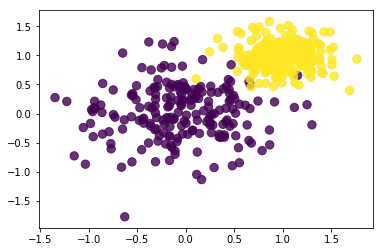

In [7]:
import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
Image('two_categories_scatter_plot.png')

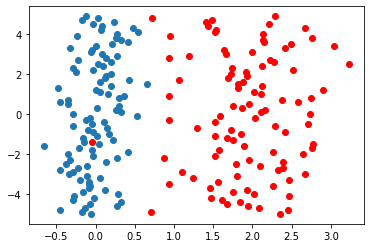

In [2]:
## generate the data and plot it for an ideal normal curve

def create_dataset(mean, dev):
    nrnd = np.random.normal(loc=mean, scale=dev, size=(100,)) # generate 100 random numbers using a Gaussian pdf
    return nrnd

samples_1 = create_dataset(0,0.25)
samples_2 = create_dataset(2,0.56)


plt.scatter(samples_1, np.arange(-5,5,0.1), marker="o")

plt.scatter(samples_2, np.arange(-5,5,0.1), marker="o",c ="r")

2\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following pickle file:
```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```
* Inspect the dataset, you'll find two variables (features)
* Convert the content to a Pandas Dataframe
* Clean the sample by selecting the entries (rows) with the absolute values of the variable "residual" smaller than 2
* Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 

Comment on the correlation between these variables.

* Create manually (without using seaborn) the profile histogram for the "distance" variable; choose an appropriate binning.
* Obtain 3 numpy arrays:
  * `x`, the array of bin centers of the profile histogram of the "distance" variable
  * `y`, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * `err_y`, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

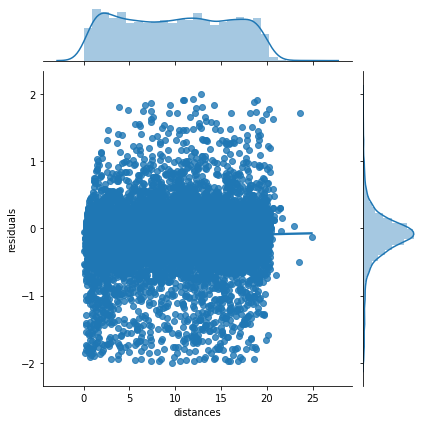

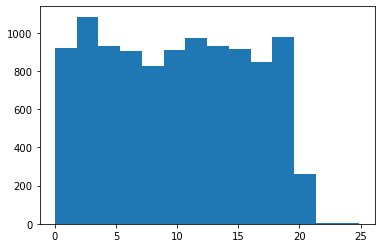

The standard deviation is: 0.02105710729284059


In [3]:
filename = "data/residuals_261.pkl"
pd_res = pd.read_pickle(filename)
df_res = pd.DataFrame(pd_res.flat[0])
df_res = df_res[df_res['residuals'].abs() < 2]
df_res.reset_index(drop=True, inplace=True)
#display(df_res)

g = sns.jointplot(data=df_res, x="distances", y="residuals", kind="reg")
#g.plot_joint(sns.regplot)
plt.show()

nbin = 14
plt.hist(data=df_res, x="distances", bins = nbin)
plt.show()

x = df_res[0::nbin]
x = x['distances']
x=x.iloc[:].values

y = df_res.groupby(np.arange(len(df_res))//nbin).mean()
y = y['residuals']
y = y.iloc[:].values

mean = y.mean()
sq = np.array([(i-mean)**2 for i in y])
err_y = sq.sum()/y.size
print("The standard deviation is: " + str(err_y))



3\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn):

* Fill a numpy array `x` of length N (with $N=\mathcal{O}(100)$) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking proper care of the aesthetic:
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* For every element of `x`, create a gaussian with the mean corresponding to the element value and the standard deviation as a parameter that can be tuned. The standard deviation default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with `np.sum()`) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method. Superimpose the normalized sum of all gaussians to the first histogram.


1000
20


ValueError: operands could not be broadcast together with shapes (300,) (1000,) 

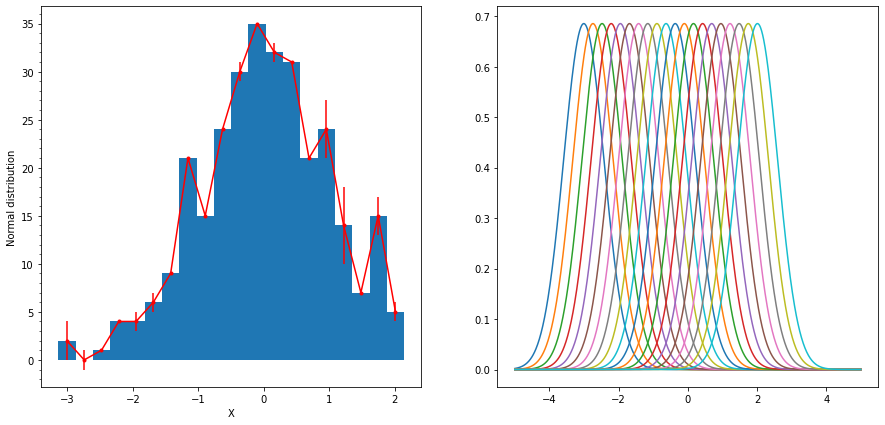

In [36]:
mean = 0
st_dev = 1
N = 300
nbins = 20

# Fixing random state for reproducibility
np.random.seed(19680801)

x = np.random.normal(mean, st_dev, N)


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

bin_counts, bin_edges, _ = ax1.hist(x, nbins)

ax1.set_ylabel("Normal distribution")
ax1.set_xlabel("X")
ax1.yaxis.set_major_locator(MultipleLocator(5))
ax1.yaxis.set_minor_locator(MultipleLocator(1))


# Generate some dummy error values, of the same dimensions as the bin counts
y_error = np.random.poisson(lam=st_dev, size=bin_centres.size)

# Plot the error bars, centred on (bin_centre, bin_count), with length y_error
ax1.errorbar(x=bin_centres, y=bin_counts, yerr=y_error, marker = '.', color="r")


constant = 1.06
st_dev_i = constant * st_dev * bin_centres.size**(-1/5)
y_i = []
i = 0
for e in bin_centres:
    y_i += [stats.norm(e, st_dev_i),]
    i += 1
    
x_ = np.arange(-5,5,0.01)
ax2.yaxis.set_ticks(np.arange(0, 2, 0.1))

y_i_pdf = []
for i in range(0,bin_centres.size):
    ax2.plot(x_,y_i[i].pdf(x_))
    y_i_pdf += [y_i[i].pdf(x_),]

sum_i = np.sum(y_i_pdf, axis = 0)

#print(sum_i.size)
#print(bin_centres.size)
#a = np.array([[sum_i],[x]])



integ = np.trapz(a, axis = 0)
integ = np.squeeze(integ)

fig1, ax = plt.subplots(nrows=1, figsize=(15, 7))
ax.yaxis.set_ticks(np.arange(0, 200, 10))
ax.plot(x_,integ)
plt.show()